In [62]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from environment import ManipulatorEnv, State
from angle_util import angle_linspace,angle_difference
from typing import List, Callable
from video_util import animate_plan

**(10 pts)** Visualize the manipulator in the start state and target state. Comment on your thoughts about comparison the discretized orientation space from PS1 vs continuous orientation space in current problem set.

In [63]:
with open('data.pickle', 'rb') as file:
    data = pickle.load(file)

start_state = np.array(data['start_state'])
goal_state = np.array(data['goal_state'])
obstacles = np.array(data['obstacles'])

print(f"Start state: \n{start_state}")
print(f"Goal state: \n{goal_state}")
print(f"Obstacles: \n{obstacles}")


Start state: 
[0. 0. 0. 0.]
Goal state: 
[-180.  -60.   72.  -60.]
Obstacles: 
[[ 2.5  1.   0.5]
 [ 1.5 -0.8  0.5]
 [-2.  -0.7  0.5]
 [-2.   1.5  0.5]
 [ 0.   1.2  0.5]
 [-0.3 -2.   0.7]]


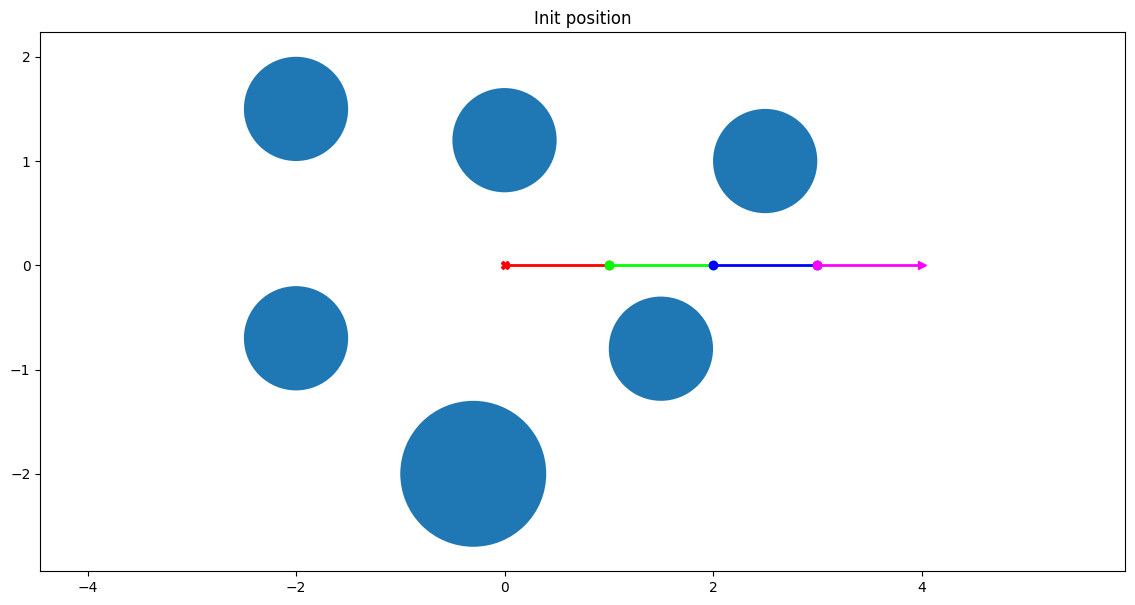

In [64]:
start_state_obj = State(start_state)
goal_state_obj = State(goal_state)
env = ManipulatorEnv(obstacles=obstacles, collision_threshold=data['collision_threshold'],initial_state=start_state_obj)
plt.figure(figsize=(14,7))
plt.title("Init position")
env.render()

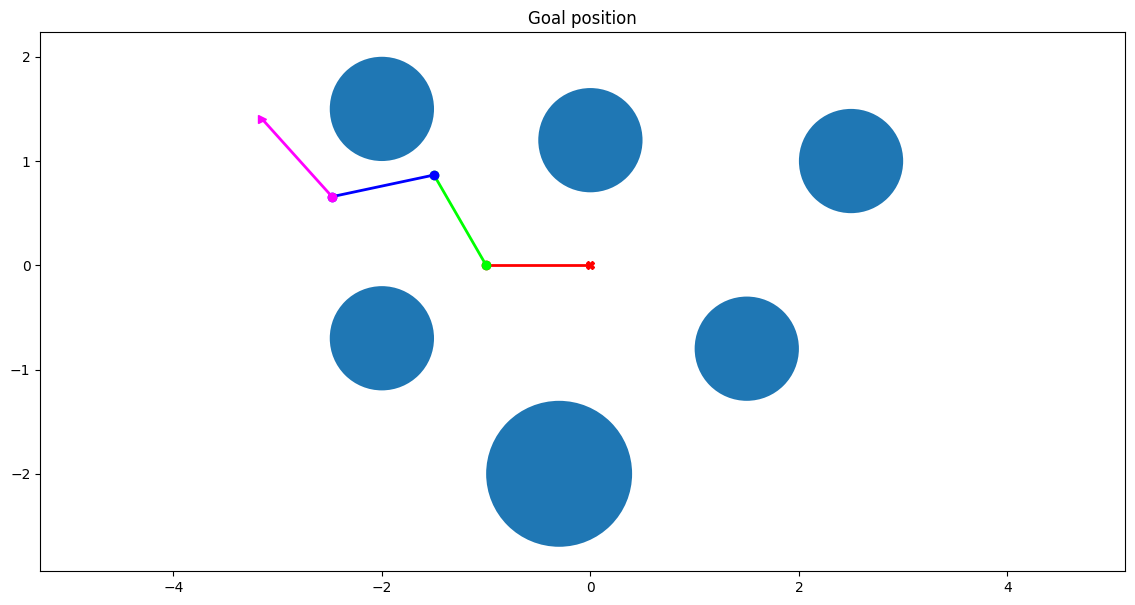

In [65]:
env.state = goal_state_obj
plt.figure(figsize=(14,7))
plt.title("Goal position")
env.render()

**Comments**:

In discrete orientation space (PS1), the work is simplified by a fixed set of possible angles, which reduces computational complexity but limits the accuracy and realism of the simulation. Some target states may be unattainable and trajectories may be jagged and less efficient. The current assignment uses a continuous orientation space, which allows for smoother and more accurate modeling of the manipulator movements, ensuring that any states are reachable and realistic planning is possible.

 However, it increases the computational cost as more configurations have to be considered and interpolation for path finding has to be used. The continuous orientation space better reflects the real-world conditions of the manipulator and is suitable for complex algorithms such as RRT, making it preferable for path planning tasks.

**(10 pts)** Visualize the manipulator in 4 random orientations that include both colliding and non-colliding configurations. Check what does the ManipulatorEnv.check_collision function returns for those configurations. Comment on your observations

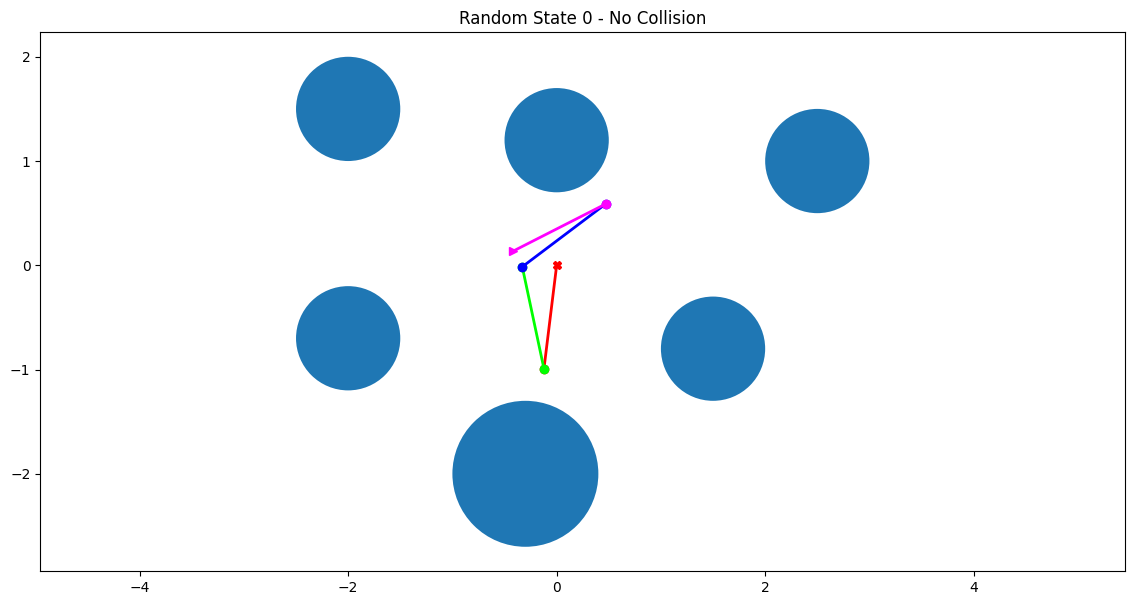

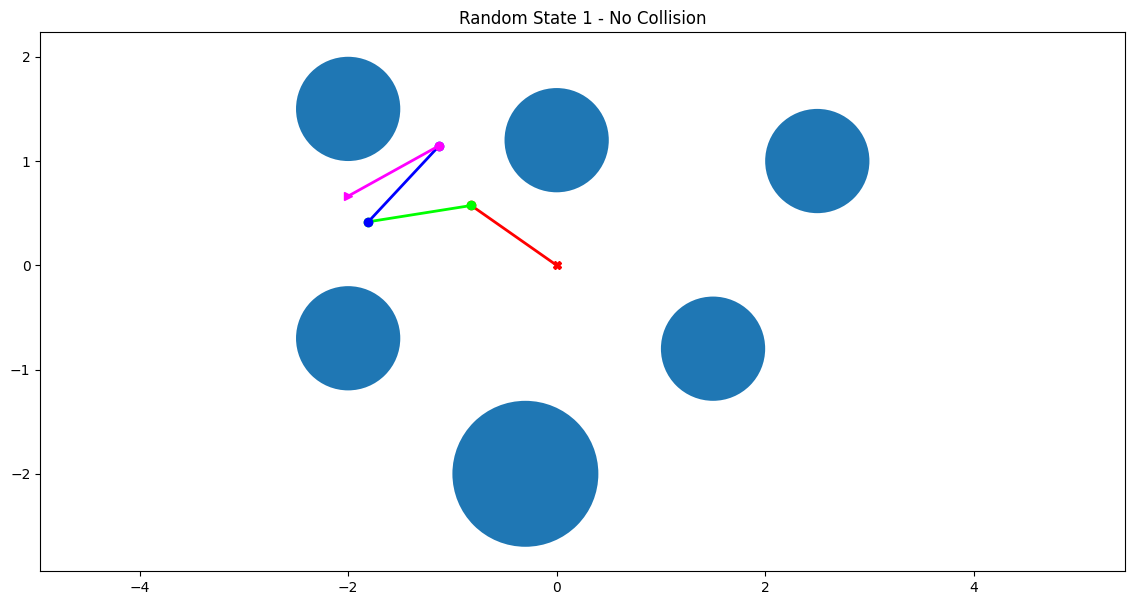

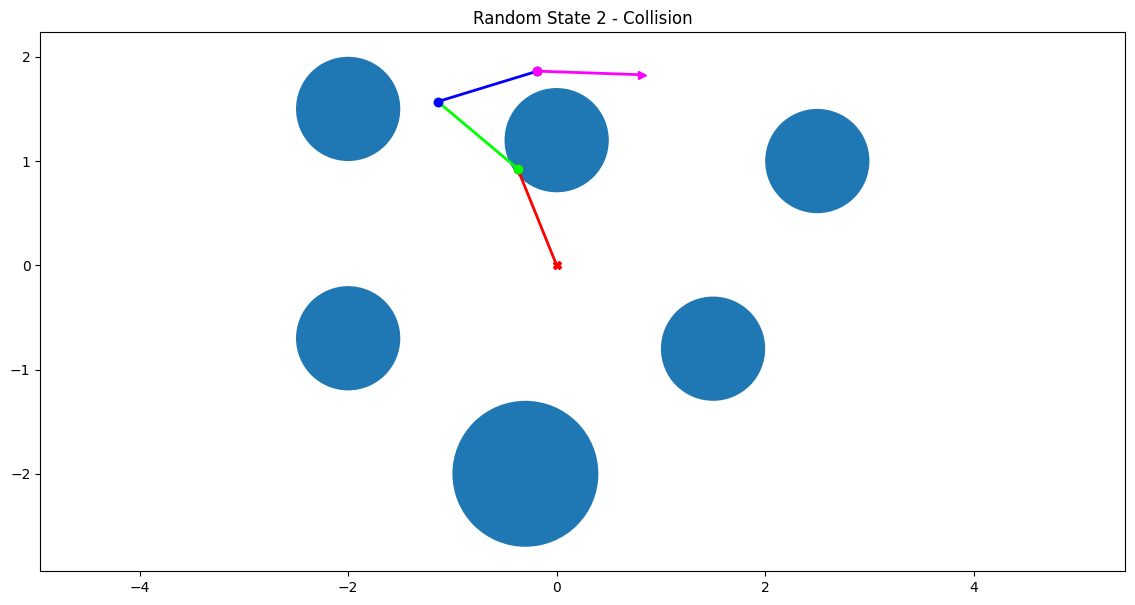

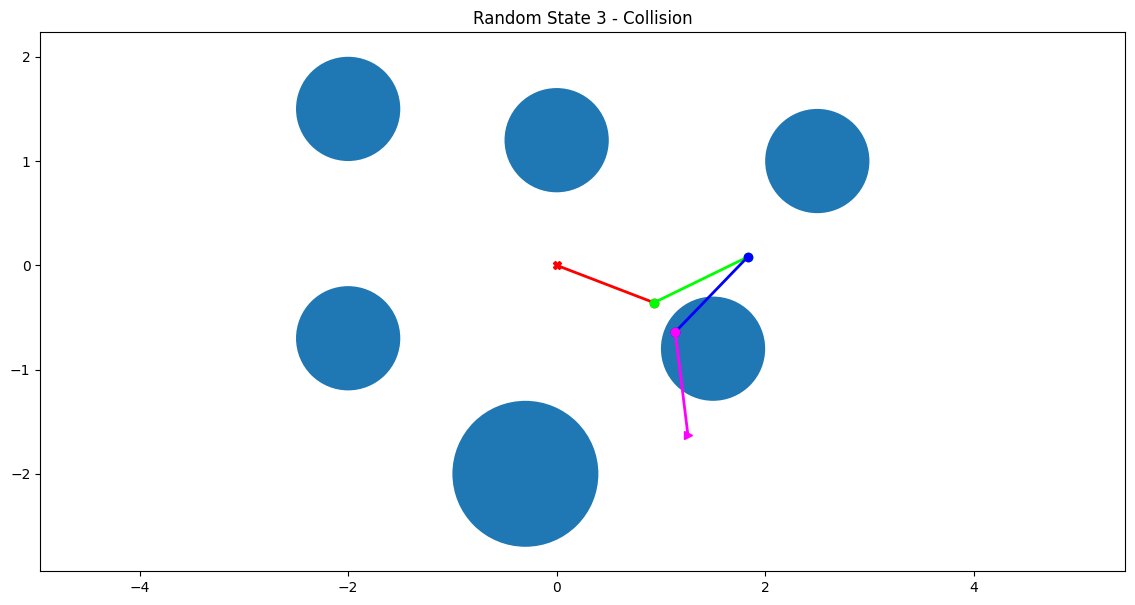

In [66]:
np.random.seed(148)
random_positions = [State(np.random.randint(-180, 180+1, size=4)) for _ in range(4)]
for i, state in enumerate(random_positions):
    env.state = random_positions[i]
    collision = env.check_collision(state)
    plt.figure(figsize=(14, 7))
    plt.title(f"Random State {i} - {'Collision' if collision else 'No Collision'}")
    env.render()

**Comments:**

The **ManipulatorEnv.check_collision** function correctly detects collisions based on the position of the manipulator segments relative to the obstacle circles. Orientations without collisions are freely placed in space, avoiding intersections with obstacles, whereas collisions have at least one segment crossing the boundaries of the circles. These results demonstrate the robustness of the collision checking feature and the importance of its use in manipulator path planning.


**(10 pts)** Implement a collision check between any two configurations. To do that, generate a random configuration q and a small increment over it, for arbitrary size. In order to implement the collision between two configurations, you have to check a sequence of configurations connecting them, in the limit representing a connectivity path as discussed in Lecture 3. Choose a sequence of some size and comment your choice. To do that, you may want to use function **angle_linspace** from **angle_utils.py**.

Also, the simple configuration check is implemented in the function **ManipulatorEnv.check_collision**,in order to check if the the manipulator is in collision at any point towards the new configuration.

Show in the same visualization the sequence of manipulator configurations for a negative collision check.

Show a second figure with a positive collision check, starting from a valid initial configuration and ending in a valid configuration but colliding on its intermediate configurations.

Collision for the first case:
Config angles: [0. 0. 0. 0.], collision: False
Config angles: [ 6. -9.  4. -4.], collision: False
Config angles: [ 12. -18.   8.  -8.], collision: False
Config angles: [ 18. -27.  12. -12.], collision: False
Config angles: [ 24. -36.  16. -16.], collision: False
Config angles: [ 30. -45.  20. -20.], collision: False
Collision for the second case:
Config angles: [0. 0. 0. 0.], collision: False
Config angles: [-36.  16.  34.  16.], collision: True
Config angles: [-72.  32.  68.  32.], collision: True
Config angles: [-108.   48.  102.   48.], collision: True
Config angles: [-144.   64.  136.   64.], collision: True
Config angles: [-180.   80.  170.   80.], collision: False


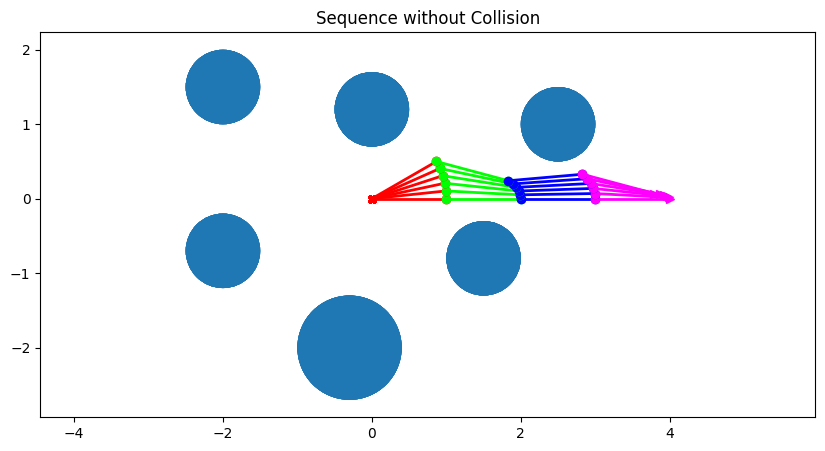

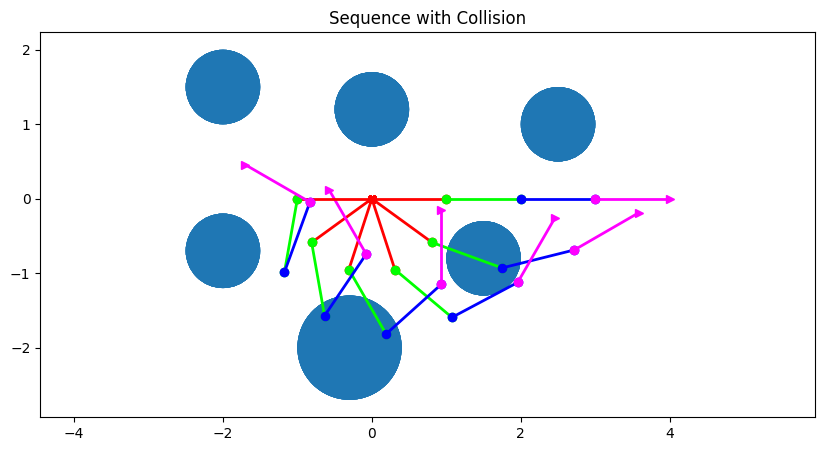

In [67]:
start_config = State(start_state)
end_config_no_collision = State(np.array([30.0, -45.0, 20.0, -20.0]))
end_config_with_collision = State(np.array([-180.0, 80.0, 170.0, 80.0]))
def check_collision_between_configs(env, start_config, end_config, num_steps=5):
    intermediate_configs = angle_linspace(start_config._angles, end_config._angles, num_steps)

    for config_angles in intermediate_configs:
        state = State(config_angles)
        if env.check_collision(state):
            print(f"Config angles: {config_angles}, collision: True")
            continue
        print(f"Config angles: {config_angles}, collision: False")  
    # return False 
print("Collision for the first case:")
no_collision = check_collision_between_configs(env, start_config, end_config_no_collision, num_steps=5)
print("Collision for the second case:")
with_collision = check_collision_between_configs(env, start_config, end_config_with_collision, num_steps=5)

plt.figure(figsize=(10, 5))
configs_no_collision = angle_linspace(start_config._angles, end_config_no_collision._angles, n=5)
for angles in configs_no_collision:
    env._state = State(angles)
    env.render(plt_show=False)
plt.title("Sequence without Collision")
plt.show()

plt.figure(figsize=(10, 5))
configs_with_collision = angle_linspace(start_config._angles, end_config_with_collision._angles, n=5)
for angles in configs_with_collision:
    env._state = State(angles)
    env.render(plt_show=False)
plt.title("Sequence with Collision")
plt.show()

In [68]:
class RRTPlanner:

    def __init__(self,
                 env: ManipulatorEnv,
                 distance_fn: Callable,
                 max_angle_step: float = 10.0):
        """
        :param env: manipulator environment
        :param distance_fn: function distance_fn(state1, state2) -> float
        :param max_angle_step: max allowed step for each joint in degrees
        """
        self._env = env
        self._distance_fn = distance_fn
        self._max_angle_step = max_angle_step


    def add_step(self,state,step):
        result = []
        for angle, step_value in zip(state.angles, step):
            new_angle = angle + step_value
            if new_angle > 180.0:
                new_angle -= 360.0
            elif new_angle < -180.0:
                new_angle += 360.0
            result.append(new_angle)
        return np.array(result)

    def plan(self,
             start_state: State,
             goal_state: State,
             max_iterations: int = 25000) -> List[State]:
        
        tree = [start_state]  
        parent_map = {0: None}  

        for _ in range(max_iterations):
            
            if np.random.rand() > 0.3:
                random_angles = np.random.randint(-180, 180, size=4)
                random_state = State(random_angles)
            else: 
                random_state = goal_state

            distances = [self._distance_fn(node.angles, random_state.angles) for node in tree]
            nearest_idx = np.argmin(distances)
            nearest_state = tree[nearest_idx]

            direction = angle_difference(random_state.angles, nearest_state.angles)
            step = np.clip(direction, -self._max_angle_step, self._max_angle_step)
            new_angles = self.add_step(nearest_state,step)
            
            new_state = State(new_angles)

            if not self._env.check_collision(new_state):
                tree.append(new_state)
                parent_map[len(tree) - 1] = nearest_idx

                if self._distance_fn(new_state.angles, goal_state.angles) < self._max_angle_step:
                    tree.append(goal_state)
                    parent_map[len(tree) - 1] = len(tree) - 2
                    break

        path = []
        current_idx = len(tree) - 1
        while current_idx is not None:
            path.append(tree[current_idx])
            current_idx = parent_map[current_idx]

        return path[::-1],len(tree) 

In [69]:
np.random.seed(None)
env = ManipulatorEnv(obstacles=np.array(data['obstacles']), collision_threshold=data['collision_threshold'],initial_state=start_state)

def distance_l1(state1, state2):
    return np.sum(np.abs(angle_difference(state1,state2)))
start_state = State(np.array([0.0, 0.0, 0.0, 0.0]))
goal_state = State(np.array([-180.0, -60.0, 72.0, -60.0]))
rrt = RRTPlanner(env=env, distance_fn=distance_l1, max_angle_step=10.0)

path,amount = rrt.plan(start_state=start_state, goal_state=goal_state)

In [70]:
animate_plan(plan=path,env=env,video_output_file ="solve_4R.mp4")
print(f"The amount of nodes: {amount}")
print(f"The trajectory size: {len(path)}")

Starting animation...
Animation saved to /Users/hermak/code/planning_2024/ps2/solve_4R.mp4
The amount of nodes: 484
The trajectory size: 64


**(10 pts)** Comment on how many states have been visited? What is the final trajectory size? Can you comment on the optimality of the plan? You can also collect some observations and statistics across multipleruns

On average, after several runs of the program, the execution time is about one and a half minutes and the trajectory length is about 65 points. The number of visited states depends on the complexity of the configuration space and the number of obstacles, but is usually much larger than the length of the final trajectory, since RRT explores many intermediate states to avoid collisions.

Regarding optimality, RRT aims at finding an admissible path rather than an optimal path. The resulting paths may be longer or contain redundant turns, since the algorithm does not consider minimizing the path length during the construction phase. Trajectory post-processing (e.g., smoothing) can be used to improve optimality.


**(10 pts)** Try to change weight of rotation in calculation of distance between two agent positions. We suggest you to build a distance function based on weighted sum of the angle distances. Comment on the results.

In [76]:
env = ManipulatorEnv(obstacles=np.array(data['obstacles']), collision_threshold=data['collision_threshold'],initial_state=start_state)

def distance_weight(state1, state2):
    weights = [1.2,1.1,1.05,1]
    distance = 0
    for inx,angle in enumerate(angle_difference(state1,state2)):
        distance+= np.abs(weights[inx]*angle)
    return distance
start_state = State(np.array([0.0, 0.0, 0.0, 0.0]))
goal_state = State(np.array([-180.0, -60.0, 72.0, -60.0]))
rrt_weight = RRTPlanner(env=env, distance_fn=distance_weight, max_angle_step=10.0)

path,amount = rrt_weight.plan(start_state=start_state, goal_state=goal_state)

In [78]:
animate_plan(plan=path,env=env,video_output_file ="solve_4R_weight.mp4")
print(f"The amount of nodes: {amount}")
print(f"The trajectory size: {len(path)}")

Starting animation...
Animation saved to /Users/hermak/code/planning_2024/ps2/solve_4R_weight.mp4
The amount of nodes: 3793
The trajectory size: 52


After the introduction of the weighted **distance_weight** function, where the angles of the first joints have more weight, the planner began to give priority to optimizing the motion of the first joints of the manipulator. This affects the trajectory structure: it becomes more predictable at the initial joints, but the movements of the far joints (with less weight) may be less optimal.

From a practical point of view, the use of a weighted metric allows to take into account the importance of different joints for a particular task, but may reduce the overall optimality of the trajectory.


**(10 pts)** Try to change step size used for RRT branches. Comment on the results.

In [73]:
np.random.seed(None)
env = ManipulatorEnv(obstacles=np.array(data['obstacles']), collision_threshold=data['collision_threshold'],initial_state=start_state)

def distance_l1(state1, state2):
    return np.sum(np.abs(angle_difference(state1,state2)))
start_state = State(np.array([0.0, 0.0, 0.0, 0.0]))
goal_state = State(np.array([-180.0, -60.0, 72.0, -60.0]))
rrt = RRTPlanner(env=env, distance_fn=distance_l1, max_angle_step=12.5)

path,amount = rrt.plan(start_state=start_state, goal_state=goal_state)

In [74]:
animate_plan(plan=path,env=env,video_output_file ="solve_4R_angle.mp4")
print(f"The amount of nodes: {amount}")
print(f"The trajectory size: {len(path)}")

Starting animation...
Animation saved to /Users/hermak/code/planning_2024/ps2/solve_4R_angle.mp4
The amount of nodes: 4353
The trajectory size: 46


Increasing the RRT step to 12.5 reduced computation time and the number of points in the trajectory as the planner explores the space more aggressively, reducing the number of intermediate configurations. However, increasing the step size can cause important configurations to be missed, especially in complex regions with narrow passages between obstacles. This increases the probability of errors, such as obstacle crossings, due to insufficient trajectory detail. In general, increasing pitch is suitable for tasks with less complex spaces, but requires caution when working in dense or narrow environments. The balance between pitch and safety remains a key factor.